## Initial imports

In [1]:
from typing import List
import scm.plams as plams
from scm.input_classes import engines
from scm.reactions_discovery import ReactionsDiscoveryJob
from rdkit import Chem
from rdkit.Chem import Draw

# Settings for displaying molecules in the notebook
from rdkit.Chem.Draw import IPythonConsole

IPythonConsole.ipython_useSVG = True
IPythonConsole.molSize = 250, 250

## Helpers for showing molecules

In [2]:
def draw_molecules(molecules: List[plams.Molecule]):
    smiles = [molecule.properties.smiles for molecule in molecules]
    return draw_smiles(smiles)


def draw_smiles(smiles: List[str]):
    rd_mols = [Chem.MolFromSmiles(s) for s in smiles]
    return Draw.MolsToGridImage(rd_mols)

## The ReactionsDiscoveryJob class

In [3]:
job = ReactionsDiscoveryJob(name="MyDiscovery")
driver = job.input
md = driver.MolecularDynamics

## Setting up the reactants for molecular dynamics

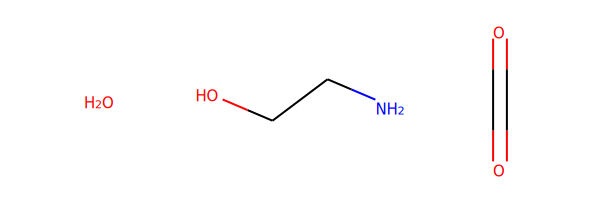

In [4]:
md.NumSimulations = 4
build = md.BuildSystem
build.NumAtoms = 250
build.Density = 0.9
build.Molecule[0].SMILES = "O"  # Water
build.Molecule[0].MoleFraction = 1
build.Molecule[1].SMILES = "NCCO"  # MEA
build.Molecule[1].MoleFraction = 2
build.Molecule[2].SMILES = "O=C=O"  # Carbondioxide
build.Molecule[2].MoleFraction = 3
draw_smiles([build.Molecule[i].SMILES.val for i in range(len(build.Molecule))])

## Setting up reactive molecular dynamics

In [5]:
md.Enabled = "Yes"
md.Type = "NanoReactor"
reactor = md.NanoReactor
reactor.NumCycles = 10
reactor.Temperature = 500
reactor.MinVolumeFraction = 0.6

## Setting up network extraction and ranking

In [6]:
network = driver.NetworkExtraction
network.Enabled = "Yes"
network.UseCharges = "Yes"
ranking = driver.ProductRanking
ranking.Enabled = "Yes"

## Selecting the AMS engine to use

In [7]:
engine = engines.ReaxFF()
engine.ForceField = "Glycine.ff"
engine.TaperBO = "Yes"  # This is a really important setting for reaction analysis with ReaxFF potentials
driver.Engine = engine

## Running reactions discovery

In [8]:
result = job.run()  # start the job
job.check()  # check if job was succesful

[04.10|16:18:26] JOB MyDiscovery STARTED
[04.10|16:18:26] JOB MyDiscovery RUNNING
[04.10|16:20:11] JOB MyDiscovery FINISHED
[04.10|16:20:11] JOB MyDiscovery SUCCESSFUL


True

## Obtain the results

In [9]:
graph, molecules, categories = result.get_network()

  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18  19  20  21  22  23  24 
 25  26  27  28  29  30  31  32  33  34  35  36  37  38  39  40  41  42  43  44  45  46  47  48  49 
 50  51  52  53  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72  73  74 
 75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90  91  92  93  94  95  96  97  98  99 
100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 
125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 
150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 
175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 
200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221 222 223 224 
225 226 227 228 229 230 231 232 233 234 235 236 237 238 239 240 241 242 243 244 245 246 247

## Categories

The categories are `Products` `Reactants` and `Unstable`, as described in the reactions discovery manual. `molecules` is a dictionairy with keys equal to the categories and each concomitant value is a list of PLAMS molecules.

In [10]:
print(categories)

['Unstable', 'Reactants', 'Products']


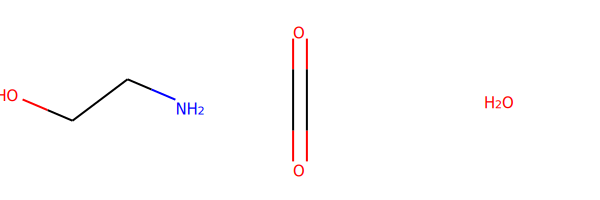

In [11]:
draw_molecules(molecules["Reactants"])

## Products

These are the side products that reactions discovery found in the order as found by the ranking algorithm.

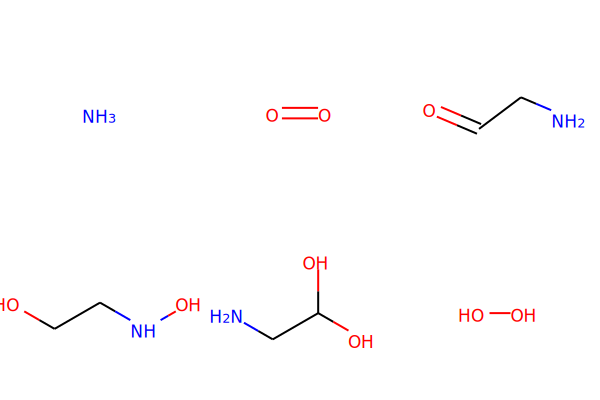

In [12]:
draw_molecules(molecules["Products"][:6])

## Unstable

Unstable products were determined to not likely exist outside of reactive dynamics. This e.g. includes radicals or structures that don't form stable molecules in isolation. Not all unstable molecules have a sensible 2d structure, so instead we plot their 3d structure.

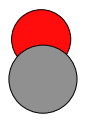

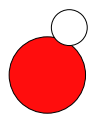

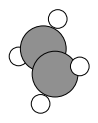

In [13]:
for unstable_molecule in molecules["Unstable"][:3]:
    plams.plot_molecule(unstable_molecule);

## Graph of the reaction network

The graph is a bipartate networkx DiGraph with reaction and molecule nodes. This can be stored on disk in standard graph formats, e.g. `.gml`

In [14]:
import networkx as nx

nx.write_gml(graph, "reaction_network.gml")

## Load a job not originally run by PLAMS

In [15]:
job = ReactionsDiscoveryJob.load_external("plams_workdir/MyDiscovery")

In [16]:
graph, molecules, categories = job.results.get_network()

  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18  19  20  21  22  23  24 
 25  26  27  28  29  30  31  32  33  34  35  36  37  38  39  40  41  42  43  44  45  46  47  48  49 
 50  51  52  53  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72  73  74 
 75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90  91  92  93  94  95  96  97  98  99 
100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 
125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 
150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 
175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 
200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221 222 223 224 
225 226 227 228 229 230 231 232 233 234 235 236 237 238 239 240 241 242 243 244 245 246 247